#### Code to train models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [4]:
from params import *

In [5]:
from data.preparation import prepare_dataframe, handle_duplicates
from data.dataset import CovidDataset
from data.transforms import get_transfos

# from model_zoo.models import define_model

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

## Data

### Load

In [10]:
df = prepare_dataframe().copy()

In [11]:
Counter(df['label'])

Counter({'opacity': 4294, 'none': 2040})

In [12]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [13]:
Counter(df['label'])

Counter({'opacity': 4372, 'none': 1962})

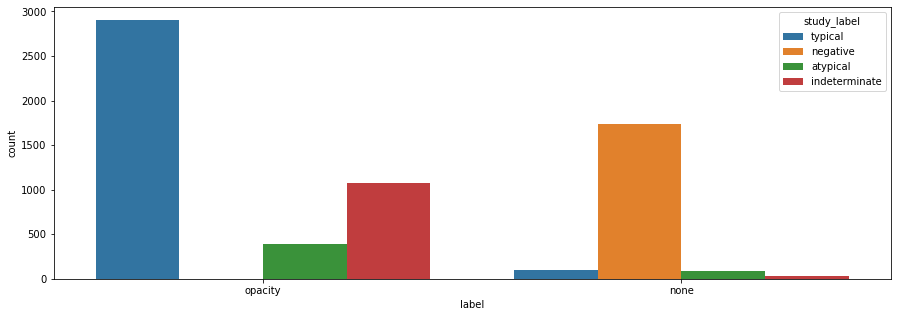

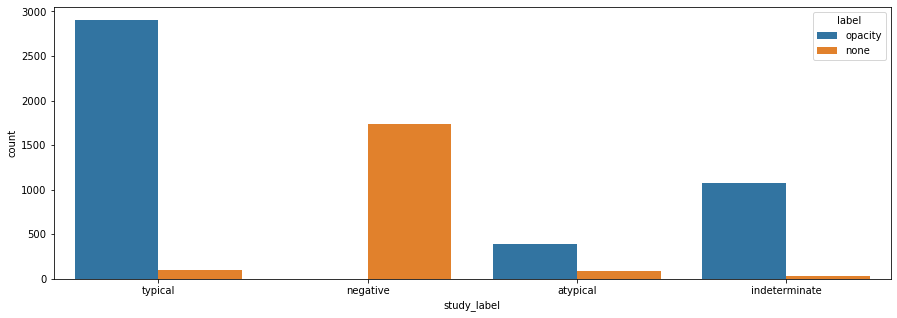

In [14]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### Dataset

In [734]:
transforms = get_transfos(augment=True, visualize=True, bbox_format="yolo")

In [735]:
dataset = CovidDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

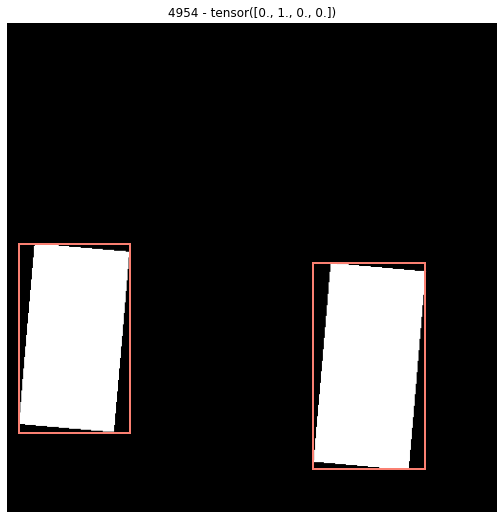

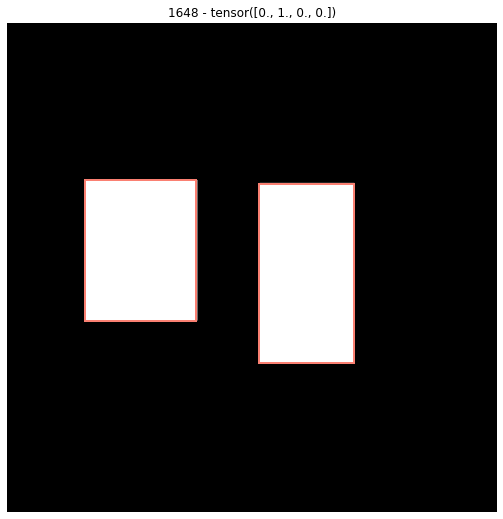

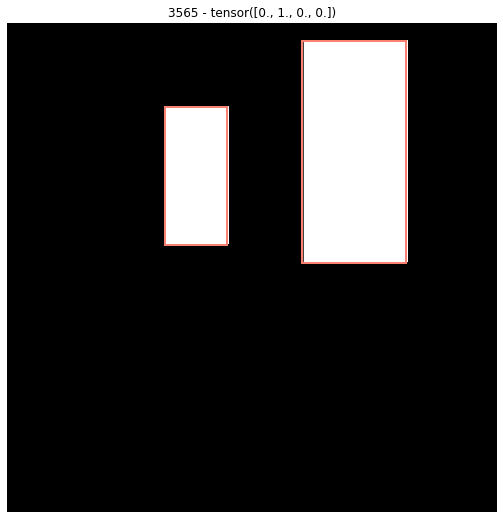

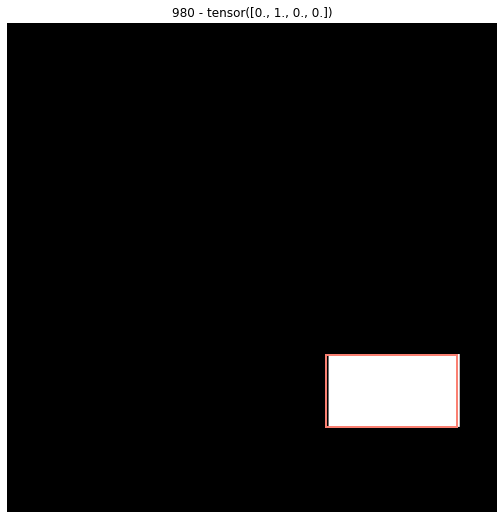

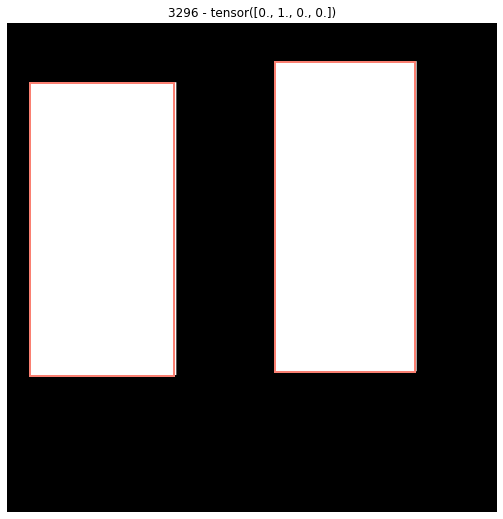

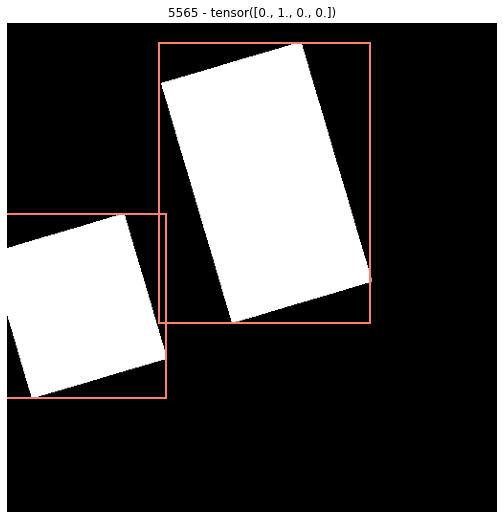

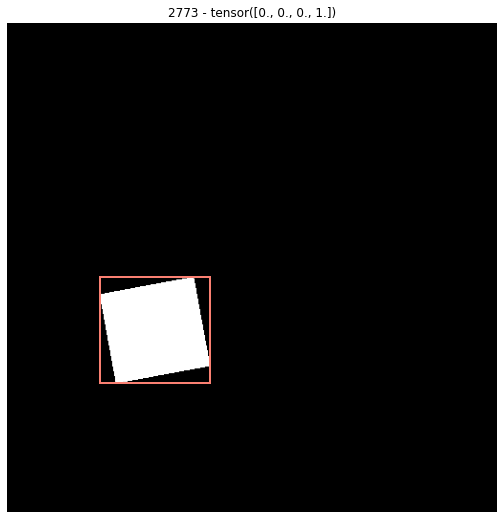

In [740]:
for i in np.random.choice(len(dataset), 10):
    img, mask, y, boxes = dataset[i]
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if len(boxes):
#         plot_sample(img, boxes, bbox_format="yolo")
        plot_sample(mask, boxes, bbox_format="yolo")
        plt.title(f'{i} - {y}')
#         break

## Model

In [791]:
transforms = get_transfos(augment=False, visualize=True, bbox_format="yolo")

dataset = CovidDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo")

In [792]:
from model_zoo.models import get_model

In [793]:
model = get_model('resnet18', reduce_stride=True)

Using cache found in /home/theo/.cache/torch/hub/pytorch_vision_v0.6.0


In [794]:
transforms = get_transfos(augment=True, visualize=False, bbox_format="yolo")
dataset = CovidDataset(df, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)

x, m, y, boxes = dataset[0]
x = x.unsqueeze(0)

In [795]:
pred = model(x)

torch.Size([1, 1, 32, 32]) torch.Size([1, 1024, 1])
torch.Size([1, 1, 32, 32]) torch.Size([1, 1024, 1])
torch.Size([1, 512])


In [796]:
pred.size()

torch.Size([1, 512])